### Using DEM to derive multiple attributes at differemt scale

Digital Elevation Models (DEMs) provide information on bare ground topography, that is, elevation irrespective of land cover such as buildings/trees. DEMs are often derived from Light Detection and Ranging (LiDAR) data sources. DEMs are used in several applications such as understanding how climatic variables change with topography, and can be used to estimate lapse rate.


In [42]:
%matplotlib inline

import datacube
from datacube.utils import geometry
import numpy as np
import xarray as xr
import rioxarray
import geojson
import json
import matplotlib.pyplot as plt
from datetime import datetime
import rasterio as rio
import numpy
from osgeo import  gdal
import numpy as np

### Load the cropped DEM

In [6]:
rc = rio.open("sa_dem30m.tif")

### TPI moving window function
Credit https://landscapearchaeology.org/2021/python-tpi/

In [10]:
#Credit - https://landscapearchaeology.org/2021/python-tpi/

# -------------- INPUT -----------------
elevation_model ="sa_dem30m.tif"
output_model = "sa_tpi_wrk.tif"


# ----------  create the moving window  ------------
r= 3 #radius in pixels
win = np.ones((2* r +1, 2* r +1))
# ----------   or, copy paste your window matrix -------------
# win = np.array( [    [0, 1, 1, 1, 0]
#                      [1, 1, 1, 1, 1],
#                      [1, 1, 0, 1, 1],
#                      [1, 1, 1, 1, 1],
#                      [0, 1, 1, 1, 0]  ])

# window radius is needed for the function,
# deduce from window size (can be different for height and width…)
r_y, r_x  = win.shape[0]//2, win.shape[1]//2
win[r_y, r_x  ]=0  # let's remove the central cell 

def view (offset_y, offset_x, shape, step=1):
    """
    Function returning two matching numpy views for moving window routines.
    - 'offset_y' and 'offset_x' refer to the shift in relation to the analysed (central) cell 
    - 'shape' are 2 dimensions of the data matrix (not of the window!)
    - 'view_in' is the shifted view and 'view_out' is the position of central cells
    (see on LandscapeArchaeology.org/2018/numpy-loops/)
    """
    size_y, size_x = shape
    x, y = abs(offset_x), abs(offset_y)
    
    x_in = slice(x , size_x, step) 
    x_out = slice(0, size_x - x, step)

    y_in = slice(y, size_y, step)
    y_out = slice(0, size_y - y, step)
 
    # the swapping trick    
    if offset_x < 0: x_in, x_out = x_out, x_in                                 
    if offset_y < 0: y_in, y_out = y_out, y_in
 
    # return window view (in) and main view (out)
    return np.s_[y_in, x_in], np.s_[y_out, x_out]

# ----  main routine  -------

dem = gdal.Open(elevation_model)
mx_z = dem.ReadAsArray()

#matrices for temporary data
mx_temp = np.zeros(mx_z.shape)
mx_count = np.zeros(mx_z.shape)

# loop through window and accumulate values
for (y,x), weight in np.ndenumerate(win):
    
    if weight == 0 : continue  #skip zero values !
    # determine views to extract data 
    view_in, view_out = view(y - r_y, x - r_x, mx_z.shape)
    # using window weights (eg. for a Gaussian function)
    mx_temp[view_out] += mx_z[view_in]  * weight
    
   # track the number of neighbours 
   # (this is used for weighted mean : Σ weights*val / Σ weights)
    mx_count[view_out] += weight

# this is TPI (spot height – average neighbourhood height)
out = mx_z - mx_temp / mx_count

# writing output 
driver = gdal.GetDriverByName('GTiff')
ds = driver.Create(output_model, mx_z.shape[1], mx_z.shape[0], 1, gdal.GDT_Float32)
ds.SetProjection(dem.GetProjection())
ds.SetGeoTransform(dem.GetGeoTransform())
ds.GetRasterBand(1).WriteArray(out)
ds = None

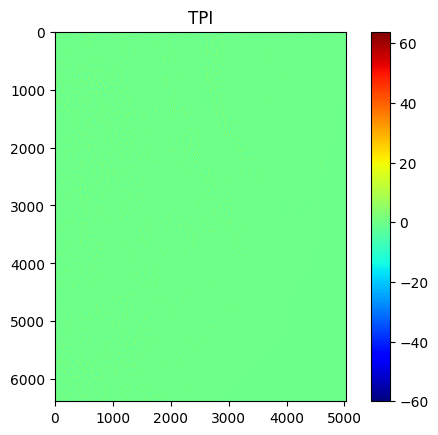

In [12]:
with rio.open("sa_tip_wrk.tif") as tw:
    tpiat1500 = tw.read(1)
plt.imshow(tpiat1500, cmap='jet')
plt.title("TPI")
plt.colorbar()

### Slope

In [38]:
from xrspatial import slope
from xrspatial import curvature
import xarray as xr

In [36]:
slope_model = "sa_slope_wrk.tif"
# loop through window and accumulate values

for (y,x), weight in np.ndenumerate(win):
    
    if weight == 0 : continue  #skip zero values !
    # determine views to extract data 
    view_in, view_out = view(y - r_y, x - r_x, mx_z.shape)
    # using window weights (eg. for a Gaussian function)
    agg = xr.DataArray(mx_z[view_out])
    mx_temp[view_out] += slope(agg)
    
   # track the number of neighbours 
   # (this is used for weighted mean : Σ weights*val / Σ weights)
    #mx_count[view_out] += weight

# this is TPI (spot height – average neighbourhood height)
out =  mx_temp

# writing output 
driver = gdal.GetDriverByName('GTiff')
ds = driver.Create(slope_model, mx_z.shape[1], mx_z.shape[0], 1, gdal.GDT_Float32)
ds.SetProjection(dem.GetProjection())
ds.SetGeoTransform(dem.GetGeoTransform())
ds.GetRasterBand(1).WriteArray(out)
ds = None

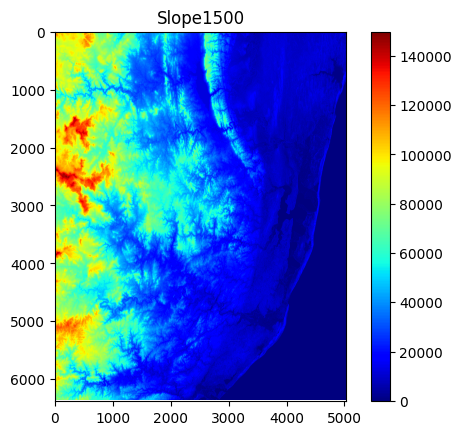

In [37]:
with rio.open(slope_model) as slpm:
    slpm1500 = slpm.read(1)
plt.imshow(slpm1500, cmap='jet')
plt.title("Slope1500")
plt.colorbar()

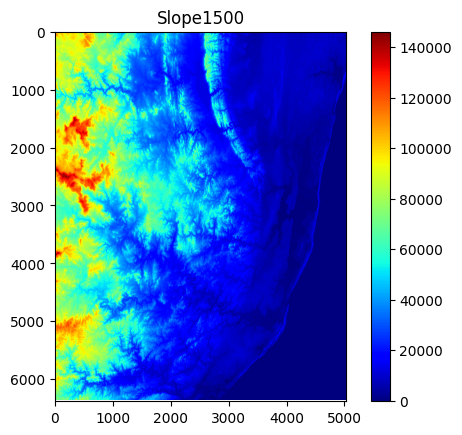

In [34]:
with rio.open(slope_model) as slpm:
    slpm1500 = slpm.read(1)
plt.imshow(slpm1500, cmap='jet')
plt.title("Slope1500")
plt.colorbar()

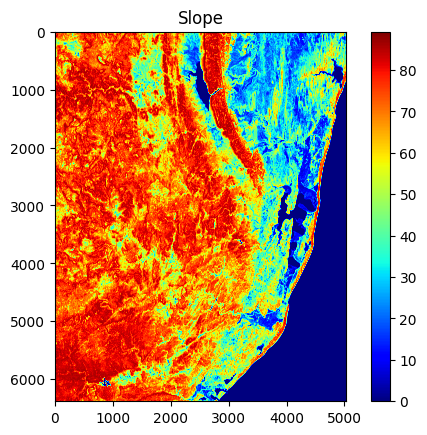

In [35]:
with rio.open('sa_dem30m_ma_slope.tif') as slpm:
    slpm1500 = slpm.read(1)
plt.imshow(slpm1500, cmap='jet')
plt.title("Slope")
plt.colorbar()

### Curvature

In [39]:
slope_model = "sa_curvature_wrk.tif"
# loop through window and accumulate values

for (y,x), weight in np.ndenumerate(win):
    
    if weight == 0 : continue  #skip zero values !
    # determine views to extract data 
    view_in, view_out = view(y - r_y, x - r_x, mx_z.shape)
    # using window weights (eg. for a Gaussian function)
    agg = xr.DataArray(mx_z[view_out])
    mx_temp[view_out] += curvature(agg)
    
   # track the number of neighbours 
   # (this is used for weighted mean : Σ weights*val / Σ weights)
    #mx_count[view_out] += weight

# this is TPI (spot height – average neighbourhood height)
out =  mx_temp

# writing output 
driver = gdal.GetDriverByName('GTiff')
ds = driver.Create(slope_model, mx_z.shape[1], mx_z.shape[0], 1, gdal.GDT_Float32)
ds.SetProjection(dem.GetProjection())
ds.SetGeoTransform(dem.GetGeoTransform())
ds.GetRasterBand(1).WriteArray(out)
ds = None

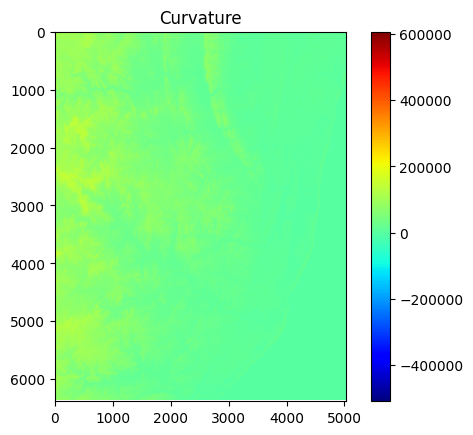

In [40]:
with rio.open('sa_curvature_wrk.tif') as slpm:
    slpm1500 = slpm.read(1)
plt.imshow(slpm1500, cmap='jet')
plt.title("Curvature")
plt.colorbar()

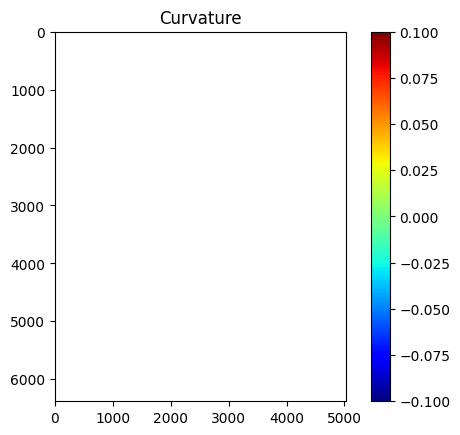

In [41]:
with rio.open('sa_dem30m_curvature.tif') as slpm:
    slpm1500 = slpm.read(1)
plt.imshow(slpm1500, cmap='jet')
plt.title("Curvature")
plt.colorbar()